In [1]:
using DrWatson
quickactivate(@__DIR__)

using NetHeider
using LinearAlgebra
using LightGraphs
using Plots
using DataFrames
using JLD2
using Statistics

In [2]:
res = jldopen(datadir("sims7", "collected_results.jld2")) do file
    file["res"]
end
first(res, 10)

,inform_every,add_edges,m_filename,pr_neg,padd,measure_balance_every_step
,Float64?,#add_sin…?,String?,Float64?,Float64?,Int64?
1,0.25,add_single_edge2!,results.csv,0.05,0.01,5
2,0.25,add_single_edge2!,results.csv,0.15,0.01,5
3,0.25,add_single_edge2!,results.csv,0.1,0.01,5
4,0.25,add_single_edge2!,results.csv,0.25,0.01,5
5,0.25,add_single_edge2!,results.csv,0.2,0.01,5
6,0.25,add_single_edge2!,results.csv,0.3,0.01,5
7,0.25,add_single_edge2!,results.csv,0.05,0.01,5
8,0.25,add_single_edge2!,results.csv,0.15,0.01,5
9,0.25,add_single_edge2!,results.csv,0.1,0.01,5


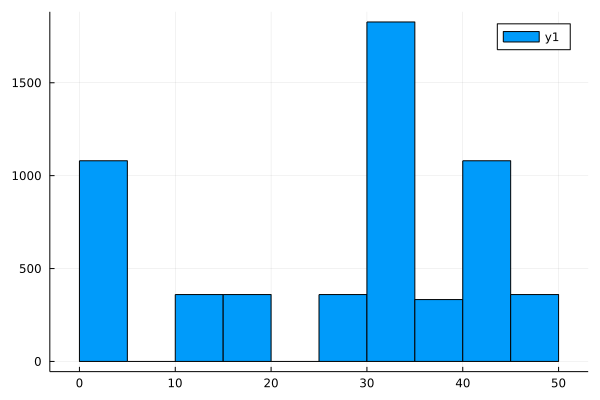

In [3]:
res.bal2bal_mean[100]
res.bu_mean[15][1,1,:]
sum(res.bu_mean[15][1,1,:])
# res.bal_unbal_table[1000][1,:,1,1]

histogram([sum(res.bu_mean[i][1,1,:]) for i in 1:nrow(res)])

In [4]:
res.bal2bal_mean[1]

80×1 Matrix{Float64}:
 0.9
 0.9
 0.9
 0.9
 0.95
 0.95
 0.9
 0.9
 0.9
 0.85
 ⋮
 0.8947368421052632
 0.8947368421052632
 1.0
 1.0
 0.9444444444444444
 0.9444444444444444
 0.9444444444444444
 0.888888888888889
 0.9444444444444444

In [24]:
names(res)[1:end]

40-element Vector{String}:
 "inform_every"
 "add_edges"
 "m_filename"
 "pr_neg"
 "padd"
 "measure_balance_every_step"
 "bal2not_mean2"
 "net_str"
 "balanced_std"
 "N"
 ⋮
 "unbal2bal_mean2"
 "triads_num"
 "last_val"
 "unbal2bal_mean"
 "attr"
 "pn"
 "save_after"
 "bal2bal_mean2"
 "path"

In [6]:
size(res)

(5760, 40)

In [32]:
unique(res.pr_pos)

6-element Vector{Union{Missing, Float64}}:
 0.05
 0.15
 0.1
 0.25
 0.2
 0.3

In [43]:
# parameters
pn = 0.8
pclose_triad = 0.35
pr_pos = pr_neg = 0.05
padd = 0.05
threshold = [0:15...]/16

fields = Symbol.(["pn", "pclose_triad", "pr_pos", "pr_neg", "padd", "threshold"])
values = []

dict = @dict pn pclose_triad pr_pos pr_neg padd threshold

L = nrow(res)

# which_rows = zeros(Bool, L)
cropped_res = deepcopy(res)
for (field, values) in dict
    inds = findall(x->x in values, cropped_res[:, field])
    # display(length(inds))
    # display(field)
    cropped_res = cropped_res[inds,:]
end

display(nrow(cropped_res))

16

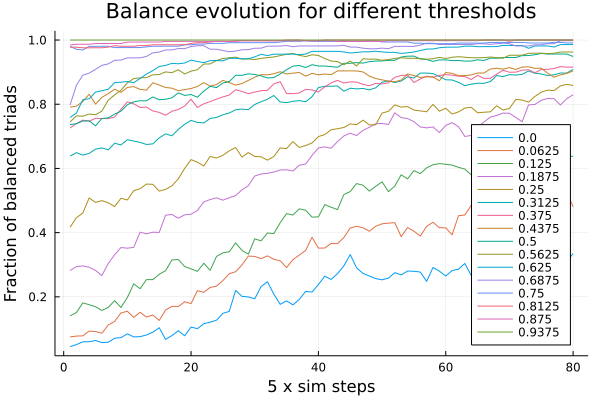

In [44]:
#balanced_mean

plot(legend = :bottomright)
for th in threshold
    ind = findall(x->x in th, cropped_res[:, :threshold])[1]
    plot!(cropped_res[ind, :balanced_mean], label = string(th))
end
plot!()
xlabel!("5 x sim steps")
ylabel!("Fraction of balanced triads")
title!("Balance evolution for different thresholds")

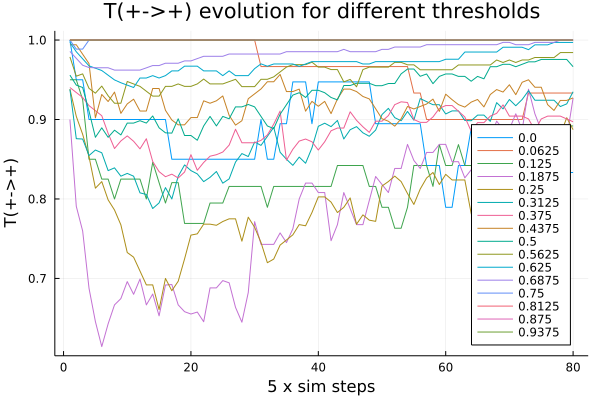

In [45]:
#bal2bal_mean, time evol

plot(legend = :bottomright)
for th in threshold
    ind = findall(x->x in th, cropped_res[:, :threshold])[1]
    plot!(cropped_res[ind, :bal2bal_mean], label = string(th))
end
plot!()
xlabel!("5 x sim steps")
ylabel!("T(+->+)")
title!("T(+->+) evolution for different thresholds")

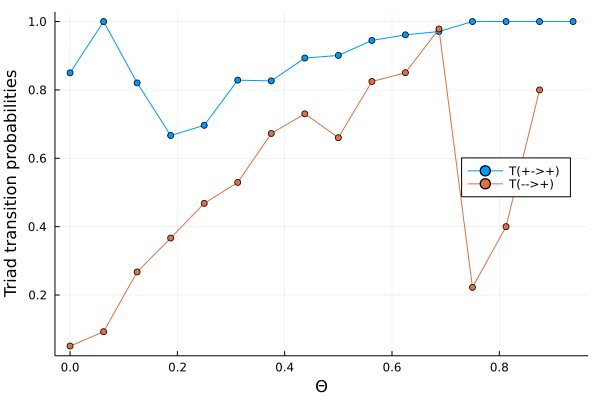

In [46]:
#bal2bal_mean, specific time

time_steps = 90
time_ind = Int(time_steps / 5)

xvals = cropped_res[:, :threshold]
yvals1 = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
plot(xvals, yvals1, markershape = :circle, label = "T(+->+)", legend = :right)#, linestyle = :none)

yvals2 = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

plot!(xvals, yvals2, markershape = :circle, label = "T(-->+)")#, linestyle = :none)


# plot(legend = :bottomright)
# for th in threshold
#     ind = findall(x->x in th, cropped_res[:, :threshold])[1]
#     plot!(cropped_res[ind, :bal2bal_mean], label = string(th))
# end
# plot!()
xlabel!("Θ")
ylabel!("Triad transition probabilities")
# title!("T(+->+) evolution for different thresholds")

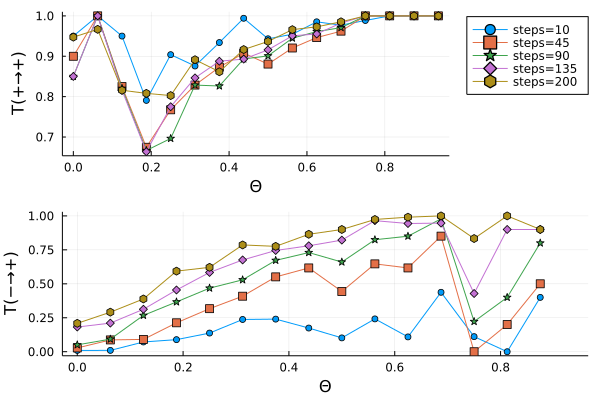

In [47]:
#bal2bal_mean, different time steps
markers = [:circle, :rect, :star5, :diamond, :hexagon, :xcross, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x, :cross]

time_stepss = [10, 45, 90, 135, 200] 
time_inds = Int.(time_stepss / 5)

p1 = plot(legend = :outertopright)
ylabel!("T(+→+)")
p2 = plot(legend = false)
ylabel!("T(−→+)")
for (i, time_ind) in enumerate(time_inds)
    xvals = cropped_res[:, :threshold]
    yvals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
    plot!(p1, xvals, yvals, markershape = markers[i], label = "steps="*string(5*time_ind))#, linestyle = :none)

    yvals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]
    plot!(p2, xvals, yvals, markershape = markers[i], label = "steps="*string(5*time_ind))#, linestyle = :none)
end
plot(p1, p2, layout = (2,1))
xlabel!("Θ")
# ylabel!(["T(+->+)" "ff"])

# title!("T(+->+) evolution for different thresholds")

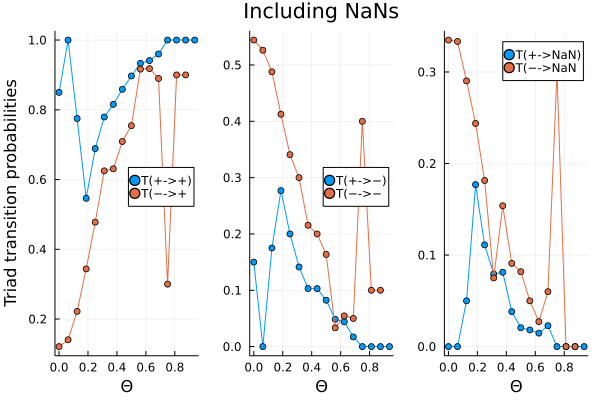

In [49]:
#bal2bal_mean2, specific time

time_steps = 135
time_ind = Int(time_steps / 5)

xvals = cropped_res[:, :threshold]
b2b = [val[time_ind] for val in cropped_res[:, :bal2bal_mean2]]
b2u = [val[time_ind] for val in cropped_res[:, :bal2unbal_mean2]]
b2n = [val[time_ind] for val in cropped_res[:, :bal2not_mean2]]
u2b = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean2]]
u2u = [val[time_ind] for val in cropped_res[:, :unbal2unbal_mean2]]
u2n = [val[time_ind] for val in cropped_res[:, :unbal2not_mean2]]

p1 = plot(xvals, b2b, markershape = :circle, label = "T(+->+)", legend = :right)#, linestyle = :none)
plot!(xvals, u2b, markershape = :circle, label = "T(−->+")

p2 = plot(xvals, b2u, markershape = :circle, label = "T(+->−)", legend = :right)#, linestyle = :none)
plot!(xvals, u2u, markershape = :circle, label = "T(−->−")

p3 = plot(xvals, b2n, markershape = :circle, label = "T(+->NaN)", legend = :topright)#, linestyle = :none)
plot!(xvals, u2n, markershape = :circle, label = "T(−->NaN")

ylabel!(p1, "Triad transition probabilities")
title!(p2, "Including NaNs")
plot(p1, p2, p3, layout = (1,3))

# plot(legend = :bottomright)
# for th in threshold
#     ind = findall(x->x in th, cropped_res[:, :threshold])[1]
#     plot!(cropped_res[ind, :bal2bal_mean], label = string(th))
# end
# plot!()
xlabel!("Θ")

# title!("T(+->+) evolution for different thresholds")

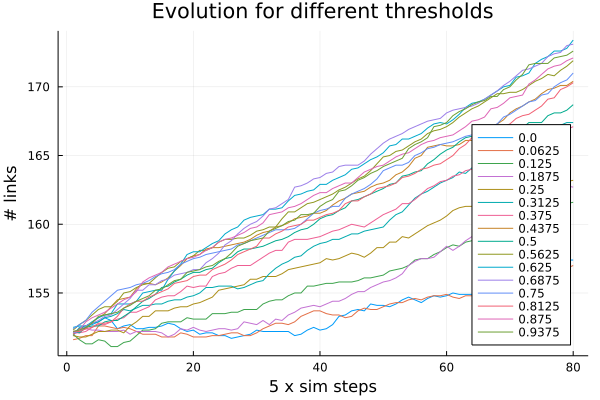

In [50]:
#links_num

plot(legend = :bottomright)
for th in threshold
    ind = findall(x->x in th, cropped_res[:, :threshold])[1]

    vals = cropped_res[ind, :links_num]'
    # display(ind)
    plot!(mean(vals, dims=2), label = string(th))
end
plot!()
xlabel!("5 x sim steps")
ylabel!("# links")
title!("Evolution for different thresholds")

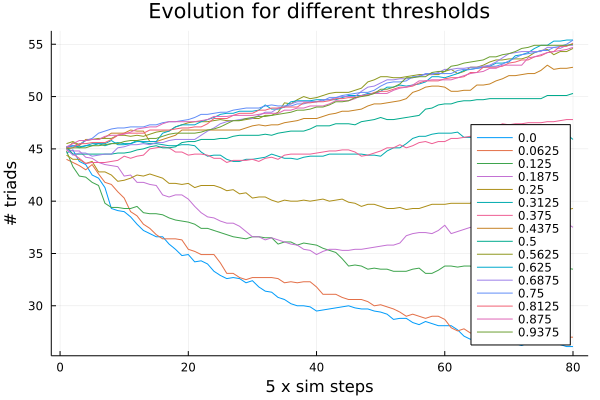

In [51]:
#triads_num

plot(legend = :bottomright)
for th in threshold
    ind = findall(x->x in th, cropped_res[:, :threshold])[1]
    vals = cropped_res[ind, :triads_num]'
    # display(ind)
    plot!(mean(vals, dims=2), label = string(th))
end
plot!()
xlabel!("5 x sim steps")
ylabel!("# triads")
title!("Evolution for different thresholds")

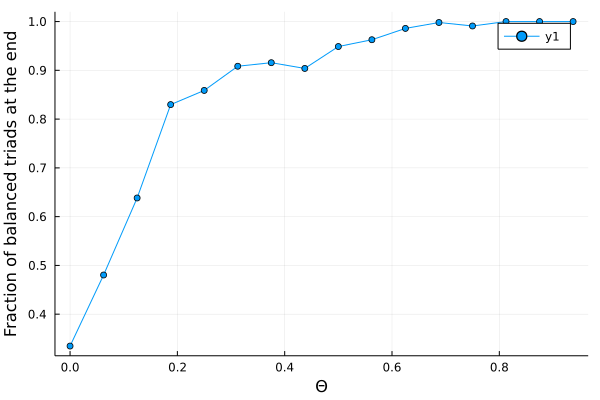

In [52]:
#last_val, specific time

# time_steps = 90
# time_ind = Int(time_steps / 10)

xvals = cropped_res[:, :threshold]
yvals1 = cropped_res[:, :last_val]
plot(xvals, yvals1, markershape = :circle)#, linestyle = :none)

# yvals2 = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

# plot!(xvals, yvals2, markershape = :circle, label = "T(-->+)")#, linestyle = :none)


# plot(legend = :bottomright)
# for th in threshold
#     ind = findall(x->x in th, cropped_res[:, :threshold])[1]
#     plot!(cropped_res[ind, :bal2bal_mean], label = string(th))
# end
# plot!()
xlabel!("Θ")
ylabel!("Fraction of balanced triads at the end")
# title!("T(+->+) evolution for different thresholds")

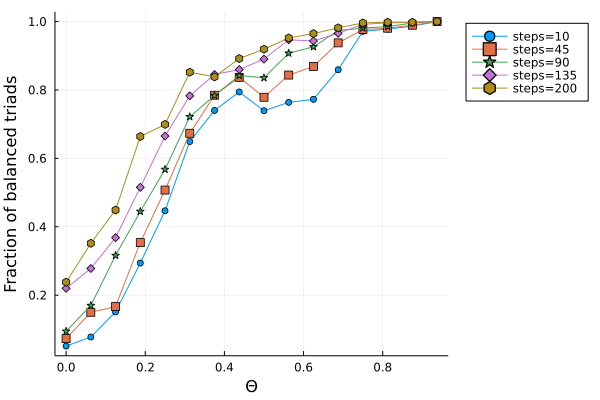

In [53]:
#balanced fraction, different time steps
markers = [:circle, :rect, :star5, :diamond, :hexagon, :xcross, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x, :cross]

time_stepss = [10, 45, 90, 135, 200] 
time_inds = Int.(time_stepss / 5)

p1 = plot(legend = :outertopright)
ylabel!("Fraction of balanced triads")
# p2 = plot(legend = false)
# ylabel!("T(−→+)")
for (i, time_ind) in enumerate(time_inds)
    xvals = cropped_res[:, :threshold]
    yvals = [val[time_ind] for val in cropped_res[:, :balanced_mean]]
    plot!(p1, xvals, yvals, markershape = markers[i], label = "steps="*string(5*time_ind))#, linestyle = :none)

    # yvals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]
    # plot!(p2, xvals, yvals, markershape = markers[i], label = "steps="*string(10*time_ind))#, linestyle = :none)
end
# plot(p1, p2, layout = (2,1))
plot(p1)
xlabel!("Θ")
# ylabel!(["T(+->+)" "ff"])

# title!("T(+->+) evolution for different thresholds")

# Finding best simulation parameters

In [54]:
real_trans_df = jldopen(datadir("exp_pro", "real_randomized_triad_trans_results.jld2")) do file
    file["res"]
end
first(real_trans_df, 10)

,threshold,netsense_b2b,netsense_u2b,node_rand_b2b,node_rand_u2b,node_rand_b2b_std
,Float64,Any,Any,Any,Any,Any
1,0.0,0.4,0.0175439,0.2,0.00258333,0.18041
2,0.0625,0.2,0.0769231,0.374167,0.0163158,0.164333
3,0.125,0.631579,0.209302,0.486538,0.0582,0.11894
4,0.1875,0.612903,0.451613,0.560926,0.120694,0.0817351
5,0.25,0.794872,0.391304,0.696765,0.224655,0.0609315
6,0.3125,0.731707,0.619048,0.752222,0.332889,0.0561586
7,0.375,0.837209,0.736842,0.776813,0.406,0.0481336
8,0.4375,0.891304,0.375,0.817742,0.371515,0.0432376
9,0.5,0.869565,0.625,0.816774,0.400303,0.0430357


In [55]:

# dict should be create the following way. df has fields :a, :b, then:
# a = [4] # where 4 is the value which extracted rows should have
# b = [2]
# dict = @dict a b
function get_part_dataframe(df::DataFrame, dict::Dict; verbose = true)
    cropped_res = deepcopy(df)
    for (field, values) in dict
        inds = findall(x->x in values, cropped_res[:, field])
        cropped_res = cropped_res[inds,:]
    end
    if verbose
        display("Extracted " * string(nrow(cropped_res)) * " rows.")
    end
    return cropped_res
end


function calc_error(b2b1, u2b1, b2b2, u2b2; method = "mse")

    b2b_non_nan = (.!(isnan.(b2b1)) .+ .!(isnan.(b2b2)) ) .== 2

    # if sum(b2b_non_nan) < length(b2b1)
    #     return calc_error(b2b1[b2b_non_nan], u2b1, b2b2[b2b_non_nan], u2b2; method = method)
    # end

    u2b_non_nan = (.!(isnan.(u2b1)) .+ .!(isnan.(u2b2)) ) .== 2

    # if sum(u2b_non_nan) < length(b2b1)
    #     return calc_error(b2b1, u2b1[u2b_non_nan], b2b2, u2b2[u2b_non_nan]; method = method)
    # end

    if method == "mse"
        error = sum((b2b1[b2b_non_nan] .- b2b2[b2b_non_nan]).^2) + sum((u2b1[u2b_non_nan] .- u2b2[u2b_non_nan]).^2)
    elseif method == "mae"
        error = sum(abs.(b2b1[b2b_non_nan] .- b2b2[b2b_non_nan])) + sum(abs.(u2b1[u2b_non_nan] .- u2b2[u2b_non_nan]))
    elseif method == "mse_notbeg"
        # b2b_non_nan[1:3] = 0
        return calc_error(b2b1[4:end], u2b1[4:end], b2b2[4:end], u2b2[4:end]; method = "mse")
    elseif method == "mae_notbeg"
        return calc_error(b2b1[4:end], u2b1[4:end], b2b2[4:end], u2b2[4:end]; method = "mae")
    end

    return error
end

calc_error (generic function with 1 method)

In [60]:
fname = datadir("exp_pro", "sim_add_each_turn_compared_to_rl_sims7.jld2")
if isfile(fname)
    results_df = jldopen(fname) do file
        file["res"]
    end
    display(first(results_df, 3))

    calc_errors = false
else
    calc_errors = true
end

true

In [61]:
# parameters
pn = unique(res.pn)
pclose_triad = unique(res.pclose_triad)
pr_pos = pr_neg = unique(res.pr_pos)
padd = unique(res.padd)
threshold = [0:15...]/16

time_points = [45, 90, 135, 180, 270]
time_inds = Int.(time_points ./ 5)

strdicts = @strdict pn padd pclose_triad pr_pos pr_neg
dicts = dict_list(strdicts)

if calc_errors
    x = dicts[1]
    results_df = DataFrame(;[Symbol(k)=>v for (k,v) in x]...)
    results_df.dict_ind = [0]
    results_df.time_ind = [0.]
    results_df.mse = [0.]
    results_df.mae = [0.]
    results_df.mse_notbeg = [0.]
    results_df.mae_notbeg = [0.]
    delete!(results_df, 1)

    for (dict_ind, dict) in enumerate(dicts)
        if dict["pr_pos"] != dict["pr_neg"]
            continue
        end
        
        cropped_res = get_part_dataframe(res, dict; verbose =false)
        if nrow(cropped_res) == 0
            display(dict)
        end
        for (i, time_ind) in enumerate(time_inds)
            xvals = cropped_res[:, :threshold]
            b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
            u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

            #sorting, just in case
            inds = sortperm(xvals)
            xvals = xvals[inds]
            b2b_vals = b2b_vals[inds]
            u2b_vals = u2b_vals[inds]

            @assert xvals == real_trans_df.threshold

            mse = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
            mae = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
            mse_notbeg = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
            mae_notbeg = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")

            x = dict
            temp_df = DataFrame(;[Symbol(k)=>v for (k,v) in x]...)
            temp_df.dict_ind = [dict_ind]
            temp_df.time_ind = [time_ind]
            temp_df.mse = [mse]
            temp_df.mae = [mae]
            temp_df.mse_notbeg = [mse_notbeg]
            temp_df.mae_notbeg = [mae_notbeg]
            
            append!(results_df, temp_df)
        end
    end

    foldername = "exp_pro"

    fname = datadir(foldername, "sim_add_each_turn_compared_to_rl_sims7.jld2")
    jldopen(fname, "w") do file
        file["res"] = results_df
    end;
end

,padd,pr_neg,pn,pclose_triad,pr_pos,dict_ind,time_ind,mse,mae
,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64
1,0.01,0.05,0.0,0.0,0.05,1,9.0,3.41053,6.14019
2,0.01,0.05,0.0,0.0,0.05,1,18.0,1.96358,4.68438
3,0.01,0.05,0.0,0.0,0.05,1,27.0,1.78264,4.53531
4,0.01,0.05,0.0,0.0,0.05,1,36.0,1.69747,4.67401
5,0.01,0.05,0.0,0.0,0.05,1,54.0,2.17295,5.88405
6,0.03,0.05,0.0,0.0,0.05,2,9.0,3.04657,5.89433
7,0.03,0.05,0.0,0.0,0.05,2,18.0,2.5476,5.01424
8,0.03,0.05,0.0,0.0,0.05,2,27.0,2.0025,4.54576
9,0.03,0.05,0.0,0.0,0.05,2,36.0,1.89928,4.80051


"Extracted 16 rows."

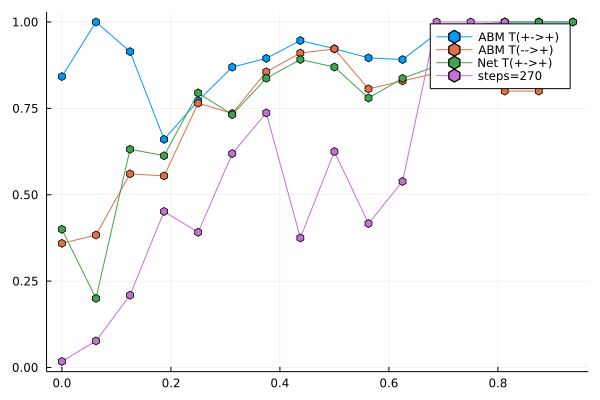

In [65]:
dict = dicts[1]
cropped_res = get_part_dataframe(res, dict)

i = 5
time_ind = Int(time_inds[5])
xvals = cropped_res[:, :threshold]
b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

plot(xvals, b2b_vals, markershape = markers[i], label = "ABM T(+->+)")#, linestyle = :none)
plot!(xvals, u2b_vals, markershape = markers[i], label = "ABM T(-->+)")#, linestyle = :none)
plot!(real_trans_df.threshold, real_trans_df.netsense_b2b, markershape = markers[i], label = "Net T(+->+)")#, linestyle = :none)
plot!(real_trans_df.threshold, real_trans_df.netsense_u2b, markershape = markers[i], label = "steps="*string(5*time_ind))#, linestyle = :none)


In [66]:
@assert xvals == real_trans_df.threshold

mse = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
mae = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
mse_notbeg = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
mae_notbeg = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")

mse, mae, mse_notbeg, mae_notbeg

(2.172948375068523, 5.884051394912722, 0.9234128913984453, 3.359668005460775)

In [68]:
cols = [:mse, :mae, :mse_notbeg, :mae_notbeg]
inds = zeros(Int, length(cols))
for (i, col) in enumerate(cols)
    inds2 = findall(results_df[:, col] .== minimum(results_df[:, col]))
    if length(inds2) > 1
        display(inds2)
    end
    inds[i] = inds2[1]
end
inds

4-element Vector{Int64}:
 199
  32
  28
  32

In [70]:
results_df[28, :dict_ind]
# results_df[665, :]
# dicts[665]

31

"Extracted 16 rows."

"Dict(\"padd\" => 0.03, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"Extracted 16 rows."

"Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"Extracted 16 rows."

"Dict(\"padd\" => 0.09, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)"

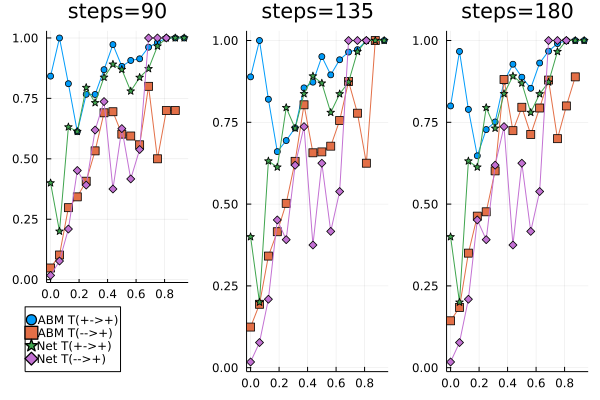

In [72]:
function plot_dict(dicts, df, param_ind)

    dict = dicts[results_df[param_ind, :dict_ind]]
    cropped_res = get_part_dataframe(res, dict)

    time_ind = Int(results_df[param_ind, :time_ind])
    xvals = cropped_res[:, :threshold]
    b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
    u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

    p1 = plot(xvals, b2b_vals, markershape = markers[1], label = "ABM T(+->+)")#, linestyle = :none)
    plot!(p1, xvals, u2b_vals, markershape = markers[2], label = "ABM T(-->+)")#, linestyle = :none)
    plot!(p1, real_trans_df.threshold, real_trans_df.netsense_b2b, markershape = markers[3], label = "Net T(+->+)")#, linestyle = :none)
    plot!(p1, real_trans_df.threshold, real_trans_df.netsense_u2b, markershape = markers[4], label = "Net T(-->+)")#, linestyle = :none)
    title!(p1, "steps="*string(5*time_ind))
    
    return p1
end

p1 = plot_dict(dicts, results_df, 32)
# title!(p1, string(dicts[results_df[665, :dict_ind]]))
display(string(dicts[results_df[32, :dict_ind]]))
p2 = plot_dict(dicts, results_df, 28)
display(string(dicts[results_df[28, :dict_ind]]))
# title!(p1, dicts[results_df[665, :dict_ind]])
p3 = plot_dict(dicts, results_df, 199)
display(string(dicts[results_df[199, :dict_ind]]))
# title!(p1, dicts[results_df[665, :dict_ind]])

plot!(p1, legend = :outertopright)
plot!(p1, legend = :outerbottom)
plot!(p2, legend = false)
plot!(p3, legend = false)

plot(p1, p2, p3, layout = (1,3))

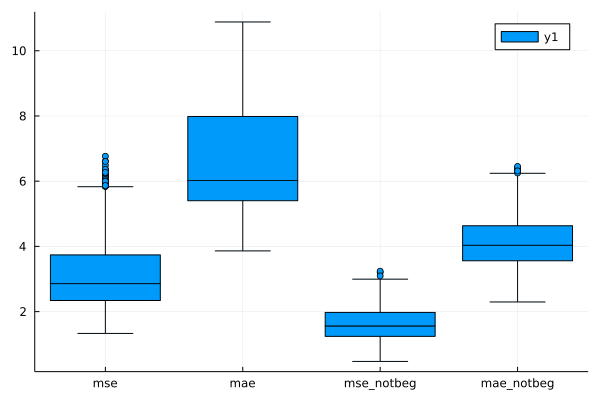

In [73]:
using StatsPlots

L = length(results_df.mse)
xvals = reduce(vcat, [repeat([i],L) for i in 1:4])
fields = [:mse, :mae, :mse_notbeg, :mae_notbeg]
yvals = reduce(vcat, [results_df[:,field] for field in fields])

boxplot(xvals, yvals, xticks = ([1, 2, 3, 4], fields))
# xticks!(["d", "e", "t"])
plot!()

In [74]:
#finding 10 best param sets

cols = [:mse, :mae, :mse_notbeg, :mae_notbeg]
mulinds = zeros(Int, length(cols), 10)
valinds = zeros(length(cols), 10)
for (i, col) in enumerate(cols)
    inds2 = partialsortperm(results_df[:, col], 1:10)
    
    mulinds[i,:] = inds2
    valinds[i,:] = results_df[inds2, col]
end
mulinds


4×10 Matrix{Int64}:
 199  224  200   28  178   32  532  179  173   198
  32   27  198   42  173  178  199   28  224   193
  28  308  199  532   32  799  178  200   53  1662
  32   28   27  198  199  308  178   39   42   173

In [75]:
valinds

4×10 Matrix{Float64}:
 1.3304    1.36886   1.38575   1.42887  …  1.47223   1.47279   1.48143
 3.86116   3.88805   3.98636   4.04584     4.15944   4.17225   4.18948
 0.471733  0.496511  0.510476  0.56615     0.598015  0.619203  0.625775
 2.29583   2.32621   2.36856   2.41559     2.49798   2.50625   2.51014

In [76]:
display(string(dicts[results_df[61, :dict_ind]]))
display(string(results_df[61, :time_ind]*5))

"Dict(\"padd\" => 0.05, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"45.0"

To summarize. 

Overall, the best results were obtained with the following parameters. 

* Dict(\"padd\" => 0.03, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05), time = 90
* Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05), time = 135

Slightly worse was:

* Dict(\"padd\" => 0.09, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05), time = 270

Looking at the previous result (the model didn't change, just the time steps), my observation is that pr=0.05, pn=0.2. padd doesn't matter when pclose_triad=0.
If pclose_triad=0.35, then padd=0.09 seems the best option. 

## Assuming pn=0.8

In [77]:
fname = datadir("exp_pro", "sim_add_each_turn_compared_to_rl_sims7_pn0_8.jld2")
if isfile(fname)
    results_df = jldopen(fname) do file
        file["res"]
    end
    display(first(results_df, 3))

    calc_errors = false
else
    calc_errors = true
end

true

In [96]:
# parameters
pn = [0.8]
pclose_triad = unique(res.pclose_triad)
pr_pos = pr_neg = unique(res.pr_pos)
padd = unique(res.padd)
threshold = [0:15...]/16

time_points = [45, 90, 135, 180, 270]
time_inds = Int.(time_points ./ 5)

strdicts = @strdict pn padd pclose_triad pr_pos pr_neg
dicts = dict_list(strdicts)

if calc_errors
    x = dicts[1]
    results_df = DataFrame(;[Symbol(k)=>v for (k,v) in x]...)
    results_df.dict_ind = [0]
    results_df.time_ind = [0.]
    results_df.mse = [0.]
    results_df.mae = [0.]
    results_df.mse_notbeg = [0.]
    results_df.mae_notbeg = [0.]
    delete!(results_df, 1)

    for (dict_ind, dict) in enumerate(dicts)   
        if dict["pr_pos"] != dict["pr_neg"]
            continue
        end
        
        cropped_res = get_part_dataframe(res, dict; verbose =false)
        if nrow(cropped_res) == 0
            display(dict)
        end
        for (i, time_ind) in enumerate(time_inds)
            xvals = cropped_res[:, :threshold]
            b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
            u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

            #sorting, just in case
            inds = sortperm(xvals)
            xvals = xvals[inds]
            b2b_vals = b2b_vals[inds]
            u2b_vals = u2b_vals[inds]

            @assert xvals == real_trans_df.threshold

            mse = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
            mae = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
            mse_notbeg = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
            mae_notbeg = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")

            x = dict
            temp_df = DataFrame(;[Symbol(k)=>v for (k,v) in x]...)
            temp_df.dict_ind = [dict_ind]
            temp_df.time_ind = [time_ind]
            temp_df.mse = [mse]
            temp_df.mae = [mae]
            temp_df.mse_notbeg = [mse_notbeg]
            temp_df.mae_notbeg = [mae_notbeg]
            
            append!(results_df, temp_df)
        end
    end


    jldopen(fname, "w") do file
        file["res"] = results_df
    end;
end

,padd,pr_neg,pn,pclose_triad,pr_pos,dict_ind,time_ind,mse,mae
,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64
1,0.01,0.05,0.8,0.0,0.05,1,9.0,2.58754,5.25482
2,0.01,0.05,0.8,0.0,0.05,1,18.0,2.10401,4.94897
3,0.01,0.05,0.8,0.0,0.05,1,27.0,2.01165,5.20661
4,0.01,0.05,0.8,0.0,0.05,1,36.0,2.08507,5.6488
5,0.01,0.05,0.8,0.0,0.05,1,54.0,2.70173,6.72132
6,0.03,0.05,0.8,0.0,0.05,2,9.0,2.89334,5.23946
7,0.03,0.05,0.8,0.0,0.05,2,18.0,2.0072,4.74018
8,0.03,0.05,0.8,0.0,0.05,2,27.0,1.82562,4.90394
9,0.03,0.05,0.8,0.0,0.05,2,36.0,1.78764,4.90275


In [97]:
cols = [:mse, :mae, :mse_notbeg, :mae_notbeg]
inds = zeros(Int, length(cols))
for (i, col) in enumerate(cols)
    inds2 = findall(results_df[:, col] .== minimum(results_df[:, col]))
    if length(inds2) > 1
        display(inds2)
    end
    inds[i] = inds2[1]
end
inds

4-element Vector{Int64}:
 143
  42
  82
  42

In [98]:
#finding 10 best param sets

cols = [:mse, :mae, :mse_notbeg, :mae_notbeg]
mulinds = zeros(Int, length(cols), 10)
valinds = zeros(length(cols), 10)
for (i, col) in enumerate(cols)
    inds2 = partialsortperm(results_df[:, col], 1:10)
    
    mulinds[i,:] = inds2
    valinds[i,:] = results_df[inds2, col]
end
mulinds


4×10 Matrix{Int64}:
 143  43   82  62   44  18   9  88  113    8
  42  27   43  82    7  92  62  32   76  122
  82  83  192  62  113  43  58  27  238  143
  42  43   27  82   28  62   9   3    7  237

In [99]:
valinds

4×10 Matrix{Float64}:
 1.71509   1.71725   1.72099   1.72686   …  1.79464   1.82464   1.82562
 4.38087   4.61125   4.62654   4.6914       4.78731   4.8464    4.84975
 0.827568  0.883385  0.886509  0.888399     0.914655  0.921568  0.922194
 2.90857   2.92523   3.01994   3.07232      3.17298   3.19725   3.19962

In [101]:
function show_res(df::DataFrame, dicts, num)
    display(string(dicts[results_df[num, :dict_ind]]))
    display(string(results_df[num, :time_ind]*5))
end

show_res(results_df, dicts, 82)
show_res(results_df, dicts, 42)
show_res(results_df, dicts, 143)
show_res(results_df, dicts, 43)


"Dict(\"padd\" => 0.03, \"pr_neg\" => 0.15, \"pn\" => 0.8, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.15)"

"90.0"

"Dict(\"padd\" => 0.07, \"pr_neg\" => 0.05, \"pn\" => 0.8, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)"

"90.0"

"Dict(\"padd\" => 0.07, \"pr_neg\" => 0.1, \"pn\" => 0.8, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.1)"

"135.0"

"Dict(\"padd\" => 0.07, \"pr_neg\" => 0.05, \"pn\" => 0.8, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)"

"135.0"

## Assuming pn=0.4

In [103]:
fname = datadir("exp_pro", "sim_add_each_turn_compared_to_rl_sims7_pn0_4.jld2")
if isfile(fname)
    results_df = jldopen(fname) do file
        file["res"]
    end
    display(first(results_df, 3))

    calc_errors = false
else
    calc_errors = true
end

true

In [104]:
# parameters
pn = [0.4]
pclose_triad = unique(res.pclose_triad)
pr_pos = pr_neg = unique(res.pr_pos)
padd = unique(res.padd)
threshold = [0:15...]/16

time_points = [45, 90, 135, 180, 270]
time_inds = Int.(time_points ./ 5)

strdicts = @strdict pn padd pclose_triad pr_pos pr_neg
dicts = dict_list(strdicts)

if calc_errors
    x = dicts[1]
    results_df = DataFrame(;[Symbol(k)=>v for (k,v) in x]...)
    results_df.dict_ind = [0]
    results_df.time_ind = [0.]
    results_df.mse = [0.]
    results_df.mae = [0.]
    results_df.mse_notbeg = [0.]
    results_df.mae_notbeg = [0.]
    delete!(results_df, 1)

    for (dict_ind, dict) in enumerate(dicts)   
        if dict["pr_pos"] != dict["pr_neg"]
            continue
        end
        
        cropped_res = get_part_dataframe(res, dict; verbose =false)
        if nrow(cropped_res) == 0
            display(dict)
        end
        for (i, time_ind) in enumerate(time_inds)
            xvals = cropped_res[:, :threshold]
            b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
            u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

            #sorting, just in case
            inds = sortperm(xvals)
            xvals = xvals[inds]
            b2b_vals = b2b_vals[inds]
            u2b_vals = u2b_vals[inds]

            @assert xvals == real_trans_df.threshold

            mse = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
            mae = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
            mse_notbeg = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
            mae_notbeg = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")

            x = dict
            temp_df = DataFrame(;[Symbol(k)=>v for (k,v) in x]...)
            temp_df.dict_ind = [dict_ind]
            temp_df.time_ind = [time_ind]
            temp_df.mse = [mse]
            temp_df.mae = [mae]
            temp_df.mse_notbeg = [mse_notbeg]
            temp_df.mae_notbeg = [mae_notbeg]
            
            append!(results_df, temp_df)
        end
    end


    jldopen(fname, "w") do file
        file["res"] = results_df
    end;
end

,padd,pr_neg,pn,pclose_triad,pr_pos,dict_ind,time_ind,mse,mae
,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64
1,0.01,0.05,0.4,0.0,0.05,1,9.0,2.71306,5.39133
2,0.01,0.05,0.4,0.0,0.05,1,18.0,1.92186,4.52926
3,0.01,0.05,0.4,0.0,0.05,1,27.0,1.51404,4.28402
4,0.01,0.05,0.4,0.0,0.05,1,36.0,1.62194,4.67626
5,0.01,0.05,0.4,0.0,0.05,1,54.0,2.17491,5.83728
6,0.03,0.05,0.4,0.0,0.05,2,9.0,2.9215,5.40167
7,0.03,0.05,0.4,0.0,0.05,2,18.0,2.32943,4.74944
8,0.03,0.05,0.4,0.0,0.05,2,27.0,1.63945,4.38353
9,0.03,0.05,0.4,0.0,0.05,2,36.0,1.99392,5.35932


In [105]:
cols = [:mse, :mae, :mse_notbeg, :mae_notbeg]
inds = zeros(Int, length(cols))
for (i, col) in enumerate(cols)
    inds2 = findall(results_df[:, col] .== minimum(results_df[:, col]))
    if length(inds2) > 1
        display(inds2)
    end
    inds[i] = inds2[1]
end
inds

4-element Vector{Int64}:
 49
 49
  3
  3

In [106]:
#finding 10 best param sets

cols = [:mse, :mae, :mse_notbeg, :mae_notbeg]
mulinds = zeros(Int, length(cols), 10)
valinds = zeros(length(cols), 10)
for (i, col) in enumerate(cols)
    inds2 = partialsortperm(results_df[:, col], 1:10)
    
    mulinds[i,:] = inds2
    valinds[i,:] = results_df[inds2, col]
end
mulinds


4×10 Matrix{Int64}:
 49   3   38  33   4   8  39  24  98  243
 49   3   38   8  33  47  32   2  48  112
  3  49  243   4  33  98  39  38  45   24
  3  49   33  38   4  47   8  32  98   24

In [107]:
valinds

4×10 Matrix{Float64}:
 1.36886   1.51404  1.60669   1.61208   …  1.71269   1.7203    1.74623
 4.17225   4.28402  4.36784   4.38353      4.52926   4.5329    4.54022
 0.619203  0.66408  0.678537  0.688076     0.754086  0.798662  0.801204
 2.55115   2.62331  2.72038   2.75058      2.88813   2.8934    2.89721

In [108]:
function show_res(df::DataFrame, dicts, num)
    display(string(dicts[results_df[num, :dict_ind]]))
    display(string(results_df[num, :time_ind]*5))
end

show_res(results_df, dicts, 3)
show_res(results_df, dicts, 49)
show_res(results_df, dicts, 33)
show_res(results_df, dicts, 38)


"Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"135.0"

"Dict(\"padd\" => 0.09, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)"

"180.0"

"Dict(\"padd\" => 0.03, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)"

"135.0"

"Dict(\"padd\" => 0.05, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)"

"135.0"

# Calculating error for edge and node randomization

In [30]:
real_trans_df

mse = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
mae = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
mse_notbeg = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
mae_notbeg = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")

mse, mae, mse_notbeg, mae_notbeg

(0.9327230755126914, 3.908759190827624, 0.8146233317693982, 3.1628818989844203)

In [31]:

mse = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
mae = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
mse_notbeg = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
mae_notbeg = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")

mse, mae, mse_notbeg, mae_notbeg

(1.257523772472556, 4.379225839404921, 1.1650954074853879, 3.798715754039451)

Apart from the error for MSE the results for ABM give better approximation of the transition probabilities. 

## Triad balanced triads density

In [38]:
dicts

2940-element Vector{Dict{String, Float64}}:
 Dict("padd" => 0.01, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.03, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.05, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.07, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.09, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.01, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.03, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.05, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.07, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.09, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 ⋮
 Dict("padd" => 0.

In [ ]:
function plot_dict(dicts, df, param_ind)

    dict = dicts[results_df[param_ind, :dict_ind]]
    cropped_res = get_part_dataframe(res, dict)

    time_ind = Int(results_df[param_ind, :time_ind])
    xvals = cropped_res[:, :threshold]
    b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
    u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

    p1 = plot(xvals, b2b_vals, markershape = markers[1], label = "ABM T(+->+)")#, linestyle = :none)
    plot!(p1, xvals, u2b_vals, markershape = markers[2], label = "ABM T(-->+)")#, linestyle = :none)
    plot!(p1, real_trans_df.threshold, real_trans_df.netsense_b2b, markershape = markers[3], label = "Net T(+->+)")#, linestyle = :none)
    plot!(p1, real_trans_df.threshold, real_trans_df.netsense_u2b, markershape = markers[4], label = "Net T(-->+)")#, linestyle = :none)
    title!(p1, "steps="*string(10*time_ind))
    
    return p1
end

p1 = plot_dict(dicts, results_df, 665)
# title!(p1, string(dicts[results_df[665, :dict_ind]]))
display(string(dicts[results_df[665, :dict_ind]]))
p2 = plot_dict(dicts, results_df, 60)
display(string(dicts[results_df[60, :dict_ind]]))
# title!(p1, dicts[results_df[665, :dict_ind]])
p3 = plot_dict(dicts, results_df, 1481)
display(string(dicts[results_df[1481, :dict_ind]]))
# title!(p1, dicts[results_df[665, :dict_ind]])

plot!(p1, legend = :outertopright)
plot!(p1, legend = :outerbottom)
plot!(p2, legend = false)
plot!(p3, legend = false)

plot(p1, p2, p3, layout = (1,3))

## Influence of different pn values for specific theta

In [121]:
threshold = [8] / 16
pn = [0.]

# parameters
# pn = [0.8]
# pclose_triad = unique(res.pclose_triad)
# pr_pos = pr_neg = unique(res.pr_pos)
# padd = unique(res.padd)
# threshold = [0:15...]/16

time_points = [45, 90, 135, 180, 270]
time_inds = Int.(time_points ./ 5)

strdicts = @strdict  threshold#padd pclose_triad pr_pos pr_neg
dicts = dict_list(strdicts)

dict = dicts[1]

cropped_res = get_part_dataframe(res, dict; verbose =false)

nrow(cropped_res)

360

In [128]:
time_ind = time_inds[5]

54

In [122]:
cropped_res.b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
cropped_res.u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]];


In [124]:
using DataFrames, GLM

lm1 = fit(LinearModel, @formula(pn ~ b2b_vals), cropped_res)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

pn ~ 1 + b2b_vals

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  -2.69315    0.533714  -5.05    <1e-06   -3.74276   -1.64355
b2b_vals      3.31005    0.552964   5.99    <1e-08    2.22258    4.39751
────────────────────────────────────────────────────────────────────────

As expected, with small threshold pn is not important. With \Theta=0.5, it is very important. 